In [1]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import yfinance as yf

In [2]:
df = yf.download('GLD', start='2008-01-01', end='2022-08-21', auto_adjust=True)
df = df[['Close']]
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


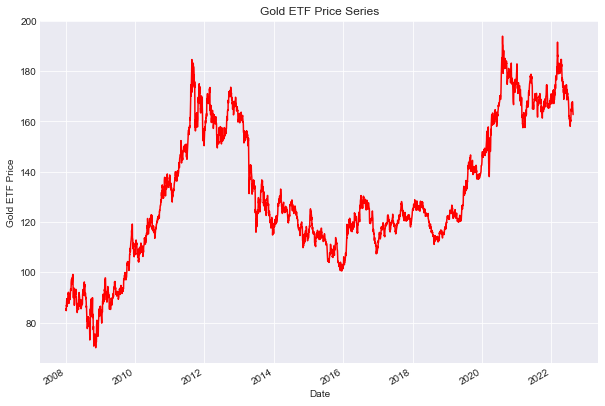

In [3]:
df.Close.plot(figsize=(10,7), color='r')
plt.ylabel('Gold ETF Price')
plt.title('Gold ETF Price Series')
plt.show()

In [5]:
df['S_3'] = df['Close'].rolling(window=3).mean()
df['S_9'] = df['Close'].rolling(window=9).mean()
df['next_day_price'] = df['Close'].shift(-1)

df = df.dropna()
X = df[['S_3', 'S_9']]

y = df['next_day_price']

In [6]:
t = .8
t = int(t*len(df))

X_train = X[:t]
y_train = y[:t]

X_test = X[t:]
y_test = y[t:]

In [8]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression Model")
print("Gold ETF Price (y) = %.2f * 3 Days Mobing Average (x1) \
    + %.2f *  9 Days Moving Average (x2) \
    + %.2f (constant) " % (linear.coef_[0], linear.coef_[1], linear.intercept_))

Linear Regression Model
Gold ETF Price (y) = 1.20 * 3 Days Mobing Average (x1)     + -0.21 *  9 Days Moving Average (x2)     + 0.43 (constant) 


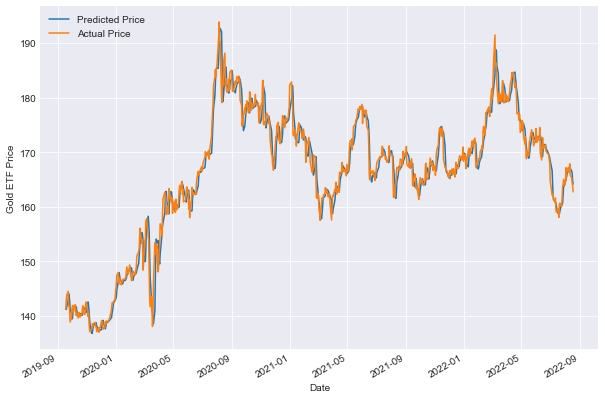

In [9]:
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10,7))
y_test.plot()
plt.legend(['Predicted Price', 'Actual Price'])
plt.ylabel('Gold ETF Price')
plt.show()

In [10]:
r2_score = linear.score(X[t:], y[t:])*100
float("{0:.2f}".format(r2_score))

97.04

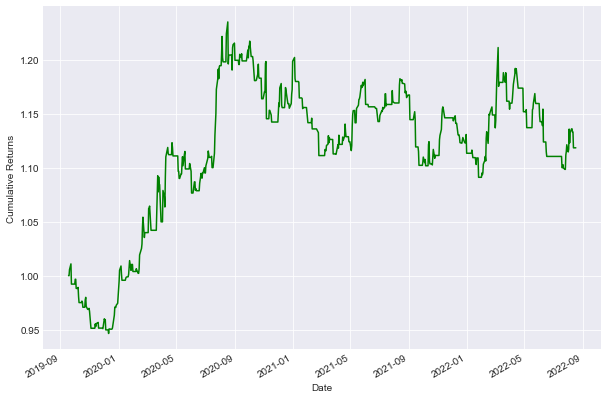

In [11]:
gold = pd.DataFrame()

gold['price'] = df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day, 1, 0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

In [12]:
# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 0.41'

In [13]:
import datetime as dt
current_date = dt.datetime.now()

# Get the data
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)
data['S_3'] = data['Close'].rolling(window=3).mean()
data['S_9'] = data['Close'].rolling(window=9).mean()
data = data.dropna()

# Forecast the price
data['predicted_gold_price'] = linear.predict(data[['S_3', 'S_9']])
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price,"Buy","No Position")

# Print the forecast
data.tail(1)[['signal','predicted_gold_price']].T